# Tutorial for [HRTFInterpAE](https://github.com/ikets/HRTFInterpAE_public)
This is a tutorial for **"Head-Related Transfer Function Interpolation from Spatially Sparse Measurements Using Autoencoder with Source Position Conditioning"** presented in IWAENC2022. 

Please cite [1] in your work when using this code in your experiments.

You can test our pretrained model with [the HUTUBUS database](http://dx.doi.org/10.14279/depositonce-8487) in this notebook.

---

[1] Yuki Ito, Tomohiko Nakamura, Shoichi Koyama, and Hiroshi Saruwatari, “Head-Related Transfer Function Interpolation from Spatially Sparse Measurements Using Autoencoder with Source Position Conditioning,” in Proc. International Workshop on Acoustic Signal Enhancement (IWAENC), Sep., 2022. (to appear)

## Install

In [1]:
%mkdir /content/HUTUBS
!wget -P /content/HUTUBS https://depositonce.tu-berlin.de/bitstream/11303/9429/3/HRIRs.zip # download the HUTUBS HRTF database

--2022-09-22 02:10:59--  https://depositonce.tu-berlin.de/bitstream/11303/9429/3/HRIRs.zip
Resolving depositonce.tu-berlin.de (depositonce.tu-berlin.de)... 130.149.196.11
Connecting to depositonce.tu-berlin.de (depositonce.tu-berlin.de)|130.149.196.11|:443... connected.
HTTP request sent, awaiting response... 200 200
Length: 1364765192 (1.3G) [application/zip]
Saving to: ‘/content/HUTUBS/HRIRs.zip’

HRIRs.zip           100%[===================>]   1.27G   854KB/s    in 26m 26s 

2022-09-22 02:37:26 (841 KB/s) - ‘/content/HUTUBS/HRIRs.zip’ saved [1364765192/1364765192]



In [2]:
%cd /content/HUTUBS
!unzip /content/HUTUBS/HRIRs.zip 

/content/HUTUBS
Archive:  /content/HUTUBS/HRIRs.zip
   creating: HRIRs/
   creating: HRIRs/Figures/
  inflating: HRIRs/Figures/pp10_HorizontalPlane.jpg  
  inflating: HRIRs/Figures/pp10_difference.pdf  
  inflating: HRIRs/Figures/pp10_selected_HRTFs.pdf  
  inflating: HRIRs/Figures/pp11_HorizontalPlane.jpg  
  inflating: HRIRs/Figures/pp11_difference.pdf  
  inflating: HRIRs/Figures/pp11_selected_HRTFs.pdf  
  inflating: HRIRs/Figures/pp12_HorizontalPlane.jpg  
  inflating: HRIRs/Figures/pp12_difference.pdf  
  inflating: HRIRs/Figures/pp12_selected_HRTFs.pdf  
  inflating: HRIRs/Figures/pp13_HorizontalPlane.jpg  
  inflating: HRIRs/Figures/pp13_difference.pdf  
  inflating: HRIRs/Figures/pp13_selected_HRTFs.pdf  
  inflating: HRIRs/Figures/pp14_HorizontalPlane.jpg  
  inflating: HRIRs/Figures/pp14_difference.pdf  
  inflating: HRIRs/Figures/pp14_selected_HRTFs.pdf  
  inflating: HRIRs/Figures/pp15_HorizontalPlane.jpg  
  inflating: HRIRs/Figures/pp15_difference.pdf  
  inflating: HRIR

In [3]:
%cd /content
!git clone https://github.com/ikets/HRTFInterpAE_public.git
%cd /content/HRTFInterpAE_public

/content
Cloning into 'HRTFInterpAE_public'...
remote: Enumerating objects: 1049, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 1049 (delta 2), reused 5 (delta 1), pack-reused 1039
Receiving objects: 100% (1049/1049), 417.11 MiB | 27.58 MiB/s, done.
Resolving deltas: 100% (330/330), done.
Checking out files: 100% (506/506), done.
/content/HRTFInterpAE_public


In [4]:
!pip install python-sofa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 49 kB 4.0 MB/s 
     |████████████████████████████████| 52 kB 1.1 MB/s 
     |████████████████████████████████| 251 kB 16.3 MB/s 


## Config

In [5]:
args_load_from = 'outputs/model_0/hrtf_interp_ae.best.net'

config = {
    'fft_length': 256,
    'max_frequency': 16000,

    'model': 'AE',
    'artifacts_dir': 'outputs/tutorial_colab',

    'channel_En_z': 128,
    'dim_z': 64,
    'channel_De_z': 128,

    'channel_hyper': 64,
    'hlayers_hyper': 1,
    'droprate': 0.0,

    'num_sub': 77, # sub for train
    'batch_size': 32, # set < VRAM(GB)/0.3
    'epochs': 1,
    'save_frequency': 400,
    'learning_rate': 0.001,
    'loss_weights': {
                        'lsd': 1,
                        'cdintra_z': 1
                    }, 
    'num_gpus': 1,
    'num_pts': 440, # B'(# measurement positions) for train/valid
    'use_itd_gt': True, # use true itd
    'fs_upsampling': 8*48000, # freq to obtain ITD
    'green': False, 
}

## Import

In [6]:
import os
import argparse
import datetime
import time
import pprint

import numpy as np
import torch as th
import matplotlib.pyplot as plt   

from src.dataset import HRTFDataset
from src.models import HRTF_Interp_AE
from src.trainer import Trainer
from src.losses import LSD, LSD_before_mean, CosDistIntra
# from src.configs import *
from src.utils import plotmaghrtf, plothrir, plotcz, hrir2itd, minphase_recon, assign_itd, posTF2IR_dim4, plotazimzeni

from torch.utils.tensorboard import SummaryWriter # tensorboard

## Define test() and main()

In [7]:
def test(net, flg_save, best_loss, data, mode, use_cuda=True):
    device = 'cuda' if use_cuda else 'cpu'
    net.to(device).eval()

    srcpos, hrtf_gt = data
    srcpos, hrtf_gt = srcpos.to(device), hrtf_gt.to(device)

    returns = {}
    lsd_loss = LSD()
    cosdist_loss = CosDistIntra()
    lsd_bm_loss = LSD_before_mean()

    keys = ["lsd", "cdintra_z"]
    for k in keys:
        returns.setdefault(k,0)
    
    subject_list = np.arange(0,srcpos.shape[-1])
    for sub_id in subject_list:
        hrtf_sub = hrtf_gt[:,:,:,sub_id:sub_id+1]
        input = th.cat((th.real(hrtf_sub[:,0,:]), th.imag(hrtf_sub[:,0,:]), th.real(hrtf_sub[:,1,:]), th.imag(hrtf_sub[:,1,:])), dim=1)
        srcpos_sub = srcpos[:,:,sub_id:sub_id+1]

        prediction = net.forward(input=input, srcpos=srcpos_sub)
        hrtf_est = prediction["output"].detach().clone()
        z_est = prediction["z"].detach().clone()

        returns["lsd"] += lsd_loss(hrtf_est, hrtf_sub)
        returns["cdintra_z"] += cosdist_loss(z_est)

        if flg_save:
            #===== Plot HRTF magnitude =====
            plotmaghrtf(srcpos=srcpos[:,:,sub_id],hrtf_gt=hrtf_gt[:,:,:,sub_id],hrtf_est=hrtf_est,mode=f'{mode}_sub-{sub_id+1}',idx_plot_list=np.array([202,211,220,229]), config=config)

            #======== Obtain HRIRs =========
            fs = config['max_frequency']*2 # sampling frequency
            f_us = config['fs_upsampling'] # frequency to calc ITD
            
            #------- Obtain true ITDs ------
            hrtf_sub = hrtf_sub.permute(3,0,1,2) # B x 2 x L x S -> S x B x 2 x L
            hrir_sub = posTF2IR_dim4(hrtf_sub)   # S x B x 2 x 2L
            if config["use_itd_gt"]: # Use true ITDs
                itd_des = hrir2itd(hrir=hrir_sub, fs=fs, f_us=f_us)
            else:
                raise NotImplementedError()

            #-- minimum phase reconstruction ---
            hrtf_est = hrtf_est.permute(3,0,1,2) # B x 2 x L x S -> S x B x 2 x L
            _, hrir_min = minphase_recon(tf=hrtf_est) # S x B x 2 x 2L
            #--------- Assign ITD ----------
            itd_ori = hrir2itd(hrir=hrir_min, fs=fs, f_us=f_us) # original ITD
            hrir_min_itd = assign_itd(hrir_ori=hrir_min, itd_ori=itd_ori, itd_des=itd_des, fs=fs) # HRIR with minimum phase & true ITD

            hrir_est = hrir_min_itd.permute(1,2,3,0) # (B,2,L,S)
            hrir_sub = hrir_sub.permute(1,2,3,0) # (B,2,L,S)
            hrtf_est = hrtf_est.permute(1,2,3,0) # (B,2,L,S)
            hrtf_sub = hrtf_sub.permute(1,2,3,0) # (B,2,L,S)
            
            #========= Plot HRIRs ==========
            plothrir(srcpos=srcpos[:,:,sub_id],mode=f'{mode}_sub-{sub_id+1}',idx_plot_list=np.array([202,211,220,229]), config=config, hrir_gt=hrir_sub.squeeze(), hrir_est=hrir_est)
            if sub_id == 0:
                hrir_gt_all = th.zeros(hrir_est.shape[0],hrir_est.shape[1],hrir_est.shape[2],len(subject_list))
                hrir_est_all = th.zeros(hrir_est.shape[0],hrir_est.shape[1],hrir_est.shape[2],len(subject_list))
                lsd_bm_all = th.zeros(hrir_est.shape[0],hrir_est.shape[1],len(subject_list)) # B,2,S
            hrir_gt_all[:,:,:,sub_id] = hrir_sub[:,:,:,0]
            hrir_est_all[:,:,:,sub_id] = hrir_est[:,:,:,0]

            #===== Plot LSDs in azimuth-zenith plane =====
            fig_dir_lsd_bm = f'{config["artifacts_dir"]}/figure/LSD/'
            os.makedirs(fig_dir_lsd_bm, exist_ok=True)
            lsd_bm = lsd_bm_loss(hrtf_est, hrtf_sub).squeeze().cpu() # (B,2)

            emphasize_mes_pos = True if "idx_mes_pos" in prediction else False
                
            for ch in range(2):
                ch_str_l = ['left', 'right']
                ch_str = ch_str_l[ch]
                plotazimzeni(pos=srcpos[:,:,sub_id].cpu(),c=lsd_bm[:,ch],fname=f'{fig_dir_lsd_bm}lsd_{mode}_sub-{sub_id+1}_{ch_str}',title=f'sub:{sub_id+1}, {ch_str}',cblabel=f'LSD (dB)',cmap='gist_heat',figsize=(10.5,5),dpi=300,emphasize_mes_pos=emphasize_mes_pos, idx_mes_pos=prediction["idx_mes_pos"],vmin=0, vmax=10)
            #===========================================

            #======== store LSD (before mean) ==========
            lsd_bm_all[:,:,sub_id] = lsd_bm

            #======== save HRIR, LSD (before mean) =====
            if sub_id == subject_list[-1]:
                hrir_dir = f'{config["artifacts_dir"]}/HRIR'
                lsd_bm_dir = f'{config["artifacts_dir"]}/LSD'
                os.makedirs(hrir_dir, exist_ok=True)
                os.makedirs(lsd_bm_dir, exist_ok=True)

                th.save(hrir_est_all, f'{hrir_dir}/HRIR_est_{mode}.pt') 
                th.save(hrir_gt_all, f'{hrir_dir}/HRIR_gt.pt') 
                th.save(lsd_bm_all, f'{lsd_bm_dir}/LSD_{mode}_before_mean.pt')

    loss = returns["lsd"]
    returns["loss"] = loss.detach().clone()
        
    for k in returns:
        returns[k] /= len(subject_list)
    
    loss_str = "    ".join([f"{k}:{returns[k]:.4}" for k in sorted(returns.keys())])
    print(loss_str)

    
    if returns["loss"] < best_loss:
        flg_save = True
        print("Best Loss.")
    if flg_save:
        print("Saving figures...")
        # Visualise
        plotmaghrtf(srcpos=srcpos[:,:,-1],hrtf_gt=hrtf_gt[:,:,:,-1],hrtf_est=hrtf_est,mode=mode,idx_plot_list=np.array([202,211,220,229]), config=config)

    return returns

def main():
    #========== set random seed ===========
    seed = 0
    np.random.seed(seed)
    th.manual_seed(seed)
    th.cuda.manual_seed(seed)

    #========== init model ===========
    net = HRTF_Interp_AE(config=config)

    os.makedirs(config["artifacts_dir"], exist_ok=True)

    #========== load dataset ===========
    dataset = HRTFDataset(config=config, sofa_path='../HUTUBS/HRIRs')
    # traindataset_all = dataset.trainitem()
    validdataset = dataset.validitem()
    testdataset = dataset.testitem()

    #====== test model =======
    print("Test model.")
    print("=====================")
    net.load_from_file(args_load_from)
    print(net)
    print("=====================")

    #--------- Estimate from B' = 9, 16,..., 196 pts (spherical t-design) ---------
    t_list = range(2,13+1) # t = 2, ..., 13

    loss_test = np.zeros((len(t_list),1))
    for t in t_list:
        config["num_pts"] = round((t+1)**2)
        print("---------------")
        print(f'{config["num_pts"]} pts (spherical t-design, t={t})')
        print("- - - - - - - -")
        
        loss = test(net=net, flg_save=True, best_loss=-1, data=testdataset, mode=f'test_t-{round(config["num_pts"]**0.5-1)}') 
        loss_test[t-2,0] = loss["lsd"]
    th.save(loss_test,config["artifacts_dir"] + f"/loss_test_t-{t_list[0]}-{t_list[-1]}.pt")

    #--------- Estimate from 440 pts (all) ----------
    print("---------------")
    print(f'440 pts (all)')
    print("- - - - - - - -")
    loss_test_all = np.zeros((1,1))
    config["num_pts"] = 440
    loss = test(net=net, flg_save=True, best_loss=-1, data=testdataset, mode=f'test_440pts')
    loss_test_all[0,0] = loss["lsd"]
    th.save(loss_test_all,config["artifacts_dir"] + f"/loss_test_all.pt")

    print("Finished!")

# Test model

In [8]:
main()

train data's mean:-0.3186933398246765, std:0.5687959790229797
Test model.
Loaded: outputs/model_0/hrtf_interp_ae.best.net
HRTF_Interp_AE(
  (Encoder_z): Sequential(
    (0): HyperLinearBlock(
      (hyperlinear): HyperLinear(
        (weight_layers): Sequential(
          (0): Linear(in_features=3, out_features=64, bias=True)
          (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (2): ReLU()
          (3): Dropout(p=0.0, inplace=False)
          (4): Linear(in_features=64, out_features=64, bias=True)
          (5): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (6): ReLU()
          (7): Dropout(p=0.0, inplace=False)
          (8): Linear(in_features=64, out_features=32768, bias=True)
        )
        (bias_layers): Sequential(
          (0): Linear(in_features=3, out_features=64, bias=True)
          (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (2): ReLU()
          (3): Dropout(p=0.0, inplace=False)
          (4): Linear(

# Visualize results

## LSDs

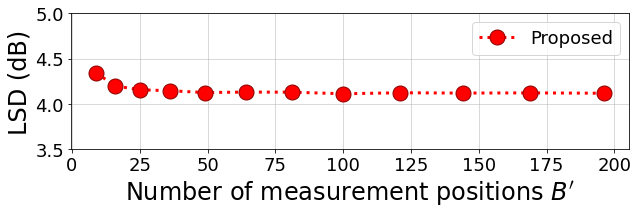

In [9]:
labelfs = 24
fs = 18
ms = 15

plt.figure(figsize=(10,2.5))
max_t = 13
t_list = np.arange(2,max_t+1)
numpts_list = (t_list+1)**2
loss_proposed = th.load('outputs/tutorial_colab/loss_test_t-2-13.pt')
# print(loss_proposed.shape)
col = 'red'
plt.plot(numpts_list,loss_proposed[:max_t+1,0],':o',linewidth=3,markerfacecolor=col,markeredgecolor='dark'+col,color=col,ms=ms,label='Proposed') # IWAENC

plt.ylim([3.5,5])

plt.xlabel(r"Number of measurement positions $B^\prime$", fontsize=labelfs)
plt.ylabel("LSD (dB)", fontsize=labelfs)

plt.grid(which="major",alpha=0.6)
plt.legend(fontsize=fs)
plt.tick_params(labelsize=fs)
plt.rcParams['figure.subplot.bottom'] = 0.15

## Magnitude frequency response

LSD: 3.0416340827941895


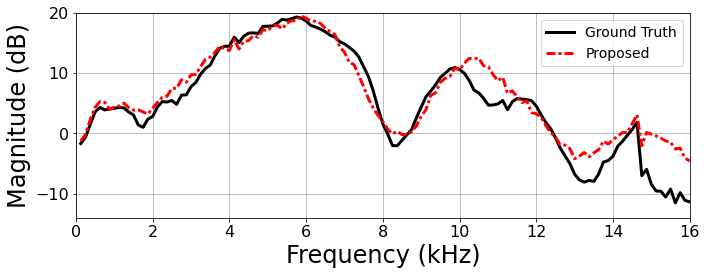

In [10]:
import torchaudio as ta

sub, idx_plot, lr = 3, 211, 0 # idxes of subject, srcpos, l/r

mag2db = ta.transforms.AmplitudeToDB(stype = 'magnitude')     
f_bin = np.linspace(0,16,129)[1:]

plt.figure(figsize=(11,3.9))
plt.rcParams['figure.subplot.bottom'] = 0.3
linewidth=3

# Ground Truth
hrir_gt = th.load('outputs/tutorial_colab/HRIR/HRIR_gt.pt')
hrtf_gt = th.conj(th.fft.fft(hrir_gt, dim=-2))[:,:,1:129,:]
HRTF_db_gt = mag2db(th.abs(hrtf_gt[idx_plot,lr,:,sub])).to('cpu').detach().numpy().copy()
plt.plot(f_bin, HRTF_db_gt, label="Ground Truth", color='0.0',linewidth=linewidth, linestyle='-')

# Proposed
hrir_est = th.load('outputs/tutorial_colab/HRIR/HRIR_est_test_t-2.pt')
hrtf_est = th.conj(th.fft.fft(hrir_est, dim=-2))[:,:,1:129,:]
HRTF_db = mag2db(th.abs(hrtf_est[idx_plot,lr,:,sub])).to('cpu').detach().numpy().copy()
print(f'LSD: {th.sqrt(th.mean((th.from_numpy((HRTF_db_gt - HRTF_db).astype(np.float32)).clone())**2))}')
plt.plot(f_bin, HRTF_db, label="Proposed", color="red",linewidth=linewidth, linestyle=(0, (3, 1, 1, 1)))

labelfs = 24
fs = 16

plt.ylim([-14,20])
plt.xlim([0,16])
plt.grid()
plt.legend()
plt.xlabel("Frequency (kHz)",fontsize=labelfs)
plt.ylabel("Magnitude (dB)",fontsize=labelfs)
plt.legend(fontsize=fs-2)
plt.tick_params(labelsize=fs)